In [31]:
import torch, torchvision
from torch.utils.data import DataLoader, random_split
import numpy as np
import matplotlib.pyplot as plt
import pyro
import tqdm
import os, pickle, re, copy
import common

In [32]:
# Reproducibility
common.set_seed(156)

In [33]:
class NN(torch.nn.Module):
    def __init__(self, ni, nh, no):
        super(NN, self).__init__()
        self.A = torch.nn.Linear(ni, nh)
        self.relu = torch.nn.ReLU()
        self.B = torch.nn.Linear(nh, no)
    def forward(self, x):
        # Two layer neural network
        x = self.B(self.relu(self.A(x)))
        return x

In [34]:
net = NN(28*28, 1024, 10)

In [35]:
def model(x, y):
    # Put priors on weights and biases 
    priors = {
        "A.weight": pyro.distributions.Normal(
            loc=torch.zeros_like(net.A.weight), 
            scale=torch.ones_like(net.A.weight),
        ).independent(2),
        "A.bias": pyro.distributions.Normal(
            loc=torch.zeros_like(net.A.bias), 
            scale=torch.ones_like(net.A.bias),
        ).independent(1),
        "B.weight": pyro.distributions.Normal(
            loc=torch.zeros_like(net.B.weight), 
            scale=torch.ones_like(net.B.weight),
        ).independent(2),
        "B.bias": pyro.distributions.Normal(
            loc=torch.zeros_like(net.B.bias), 
            scale=torch.ones_like(net.B.bias),
        ).independent(1),
    }
    # Create a NN module using the priors
    lmodule = pyro.random_module("module", net, priors)
    regressor = lmodule()
    # Do a forward pass on the NN module, i.e. yhat=f(x) and condition on yhat=y
    lhat = torch.nn.LogSoftmax(dim=1)(regressor(x))
    pyro.sample("obs", pyro.distributions.Categorical(logits=lhat).independent(1), obs=y)

In [36]:
softplus = torch.nn.Softplus()
def guide(x, y):
    # Create parameters for variational distribution priors
    Aw_mu = pyro.param("Aw_mu", torch.randn_like(net.A.weight))
    Aw_sigma = softplus(pyro.param("Aw_sigma", torch.randn_like(net.A.weight)))
    Ab_mu = pyro.param("Ab_mu", torch.randn_like(net.A.bias))
    Ab_sigma = softplus(pyro.param("Ab_sigma", torch.randn_like(net.A.bias)))
    Bw_mu = pyro.param("Bw_mu", torch.randn_like(net.B.weight))
    Bw_sigma = softplus(pyro.param("Bw_sigma", torch.randn_like(net.B.weight)))
    Bb_mu = pyro.param("Bb_mu", torch.randn_like(net.B.bias))
    Bb_sigma = softplus(pyro.param("Bb_sigma", torch.randn_like(net.B.bias)))
    # Create random variables similarly to model
    priors = {
        "A.weight": pyro.distributions.Normal(loc=Aw_mu, scale=Aw_sigma).independent(2),
        "A.bias": pyro.distributions.Normal(loc=Ab_mu, scale=Ab_sigma).independent(1),
        "B.weight": pyro.distributions.Normal(loc=Bw_mu, scale=Bw_sigma).independent(2),
        "B.bias": pyro.distributions.Normal(loc=Bb_mu, scale=Bb_sigma).independent(1),
    }
    # Return NN module from these random variables
    lmodule = pyro.random_module("module", net, priors)
    return lmodule()

In [37]:
# Do stochastic variational inference to find q(w) closest to p(w|D)
svi = pyro.infer.SVI(
    model, guide, pyro.optim.Adam({'lr': 0.01}), pyro.infer.Trace_ELBO(),
)

In [38]:
def train_and_save_models(epochs = 10, K = 100, modelname = "model.pt"):
    if os.path.exists(modelname):
        print("File exists")
        return
    # Train with SVI
    for epoch in range(epochs):
        loss = 0.
        for data in train_loader:
            images, labels = data
            images = images.view(-1, 28*28)
            loss += svi.step(images, labels)
        loss /= len(train_loader.dataset)
        print("Epoch %g: Loss = %g" % (epoch, loss))
    # Sample k models from the posterior
    sampled_models = [guide(None, None) for i in range(K)]
    # Save the models
    nn_dicts = []
    for i in range(len(sampled_models)):
        nn_dicts += [sampled_models[i].state_dict()]
    torch.save(nn_dicts, modelname)
    print("Saved %d models" % K)

In [39]:
def load_models(K = 100, model_name="model.pt"):
    # Load the models
    sampled_models = [NN(28*28, 1024, 10) for i in range(K)]
    for net, state_dict in zip(sampled_models, torch.load("models/%s" % model_name)):
        net.load_state_dict(state_dict)
    print("Loaded %d sample models" % K)
    return sampled_models

train_and_save_models(epochs = 10, K = 100, modelname = "model.pt")

## Train without Adversarial Examples

In [10]:
# Train dataset
train_dataset = torchvision.datasets.MNIST('.', train=True, download=True,
                       transform=torchvision.transforms.ToTensor())

train, val = random_split(train_dataset,[50000,10000], generator=torch.Generator().manual_seed(156))

# Train data loader
train_loader = torch.utils.data.DataLoader(train, batch_size=128, shuffle=True)
val_loader   = torch.utils.data.DataLoader(val  , batch_size=128, shuffle=True)

test_dataset = torchvision.datasets.MNIST('.', train=False, download=True,
                       transform=torchvision.transforms.ToTensor())
test_loader  = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=True)

In [12]:
epochs = 20
K = 100
modelname = "BNN"
# Train with SVI
val_losses = []
for epoch in range(epochs):
    loss = 0.
    for data in train_loader:
        images, labels = data
        images = images.view(-1, 28*28)
        loss  += svi.step(images, labels)
    loss /= len(train_loader.dataset)
    # Evaluation
    val_loss = 0.
    for data in val_loader:
        images, labels = data
        images = images.view(-1, 28*28)
        val_loss += svi.evaluate_loss(images, labels)
    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)
    print("Epoch %g: Loss = %g: Val_Loss = %g" % (epoch, loss,val_loss))
    if val_loss == min(val_losses):
        print("New minimum loss was reached")
        # Sample k models from the posterior
        sampled_models = [guide(None, None) for i in range(K)]
        # Save the models
        nn_dicts = []
        for i in range(len(sampled_models)):
            nn_dicts += [sampled_models[i].state_dict()]
        torch.save(nn_dicts, "models/%s_%s.pt" % (modelname, round(val_loss,5)))
        print("Saved %d models" % K)

Epoch 0: Loss = 2370.3: Val_Loss = 854.657
New minimum loss was reached
Saved 100 models
Epoch 1: Loss = 497.245: Val_Loss = 290.611
New minimum loss was reached
Saved 100 models
Epoch 2: Loss = 205.638: Val_Loss = 155.894
New minimum loss was reached
Saved 100 models
Epoch 3: Loss = 130.801: Val_Loss = 117.28
New minimum loss was reached
Saved 100 models
Epoch 4: Loss = 105.963: Val_Loss = 100.841
New minimum loss was reached
Saved 100 models
Epoch 5: Loss = 96.4253: Val_Loss = 95.1524
New minimum loss was reached
Saved 100 models
Epoch 6: Loss = 91.376: Val_Loss = 90.8357
New minimum loss was reached
Saved 100 models
Epoch 7: Loss = 87.7963: Val_Loss = 88.8543
New minimum loss was reached
Saved 100 models
Epoch 8: Loss = 87.1672: Val_Loss = 88.7424
New minimum loss was reached
Saved 100 models
Epoch 9: Loss = 86.3191: Val_Loss = 89.4872
Epoch 10: Loss = 86.4159: Val_Loss = 88.4104
New minimum loss was reached
Saved 100 models
Epoch 11: Loss = 86.3792: Val_Loss = 88.6365
Epoch 12: Los

In [11]:
class NN(torch.nn.Module):
    def __init__(self, ni, nh, no):
        super(NN, self).__init__()
        self.A = torch.nn.Linear(ni, nh)
        self.relu = torch.nn.ReLU()
        self.B = torch.nn.Linear(nh, no)
        self.logsoftmax = torch.nn.LogSoftmax(dim=-1)
    def forward(self, x):
        # Two layer neural network
        x = self.B(self.relu(self.A(x)))
        x = self.logsoftmax(x)
        return x

In [ ]:
# HyperParameters
epochs = 10
modelname = "FFNN"
lr     = 0.01

# Train with BinaryCrossEntropy
val_losses = []
model = NN(28*28, 1024, 10)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
loss_fcn  = torch.nn.NLLLoss()

for epoch in range(epochs):
    total_loss = 0.
    model.train()
    for data in train_loader:
        images, labels = data
        images = images.view(-1, 28*28)
        y = model(images)
        loss = loss_fcn(y, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()        
        total_loss += loss.item()
    total_loss /= len(train_loader.dataset)
    print("Epoch %g: Loss = %g" % (epoch, total_loss))

torch.save(model, "models/%s.pt" % modelname)
print("Saved the model")

## Training BNN with Adversarial Examples

### Populate Train Set

In [22]:
# Train dataset
train_dataset = torchvision.datasets.MNIST('.', train=True, download=True,
                       transform=torchvision.transforms.ToTensor())

#### loading adversarial examples

In [23]:
dirs    = [d for d in os.listdir("mnist_adv/") if d.startswith("train_images_champ")]
dir_ord = sorted([int(re.findall("[0-9]+",d)[0]) for d in dirs])
dirs    = sorted(dirs, key=lambda x: dir_ord.index(int(re.findall("[0-9]+",x)[0])))

In [24]:
images  = []
targets = []
for d in dirs[:100]:
    with open("mnist_adv/" + d, 'rb') as handle:
        temp = pickle.load(handle)
        images.append(temp["images"])
        targets.append(temp["labels"])
        
images  = torch.vstack(images)
targets = torch.hstack(targets)

In [25]:
train_dataset.data    = torch.vstack([train_dataset.data, images])
train_dataset.targets = torch.hstack([train_dataset.targets, targets])

train, val = random_split(train_dataset,[50000+images.shape[0],10000], generator=torch.Generator().manual_seed(156))

# Train data loader
train_loader = torch.utils.data.DataLoader(train, batch_size=128, shuffle=True)
val_loader   = torch.utils.data.DataLoader(val  , batch_size=128, shuffle=True)

In [26]:
img = next(iter(train_loader))

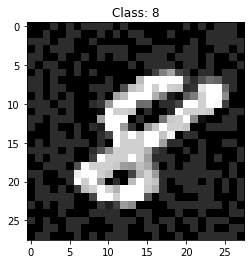

In [27]:
ind = 9 # try 1
plt.figure()
plt.imshow(img[0][ind,0,:,:], cmap='gray')
plt.title("Class: %s" % img[1][ind].item())
plt.show()

## Model Training

### AdvBNN

In [29]:
epochs = 10
K = 100
modelname = "AdvBNN_champ_eps0.18"
# Train with SVI
val_losses = []
for epoch in range(epochs):
    loss = 0.
    for data in train_loader:
        images, labels = data
        images = images.view(-1, 28*28)
        loss  += svi.step(images, labels)
    loss /= len(train_loader.dataset)
    # Evaluation
    val_loss = 0.
    for data in val_loader:
        images, labels = data
        images = images.view(-1, 28*28)
        val_loss += svi.evaluate_loss(images, labels)
    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)
    print("Epoch %g: Loss = %g: Val_Loss = %g" % (epoch, loss,val_loss))
    if val_loss == min(val_losses):
        print("New minimum loss was reached")
        # Sample k models from the posterior
        sampled_models = [guide(None, None) for i in range(K)]
        # Save the models
        nn_dicts = []
        for i in range(len(sampled_models)):
            nn_dicts += [sampled_models[i].state_dict()]
        torch.save(nn_dicts, "models/%s_%s.pt" % (modelname, val_loss))
        print("Saved %d models" % K)

Epoch 0: Loss = 88.2253: Val_Loss = 88.6896
New minimum loss was reached
Saved 100 models
Epoch 1: Loss = 86.894: Val_Loss = 86.0552
New minimum loss was reached
Saved 100 models
Epoch 2: Loss = 86.8599: Val_Loss = 87.0401
Epoch 3: Loss = 86.5119: Val_Loss = 87.8889
Epoch 4: Loss = 87.1113: Val_Loss = 86.2929
Epoch 5: Loss = 87.3033: Val_Loss = 86.7481
Epoch 6: Loss = 86.679: Val_Loss = 86.8712
Epoch 7: Loss = 86.8535: Val_Loss = 86.5329
Epoch 8: Loss = 86.3234: Val_Loss = 87.3801
Epoch 9: Loss = 86.9357: Val_Loss = 87.2249


### AdvFFNN

In [ ]:
class NN(torch.nn.Module):
    def __init__(self, ni, nh, no):
        super(NN, self).__init__()
        self.A = torch.nn.Linear(ni, nh)
        self.relu = torch.nn.ReLU()
        self.B = torch.nn.Linear(nh, no)
        self.logsoftmax = torch.nn.LogSoftmax(dim=-1)
    def forward(self, x):
        # Two layer neural network
        x = self.B(self.relu(self.A(x)))
        x = self.logsoftmax(x)
        return x
class DeepNN(torch.nn.Module):
    def __init__(self, ni, nh, no):
        super(DeepNN, self).__init__()
        self.fwd = torch.nn.Sequential(
            torch.nn.Linear(ni, nh), torch.nn.ReLU(),
            torch.nn.Linear(nh, nh), torch.nn.ReLU(),
            torch.nn.Linear(nh, no),
            torch.nn.LogSoftmax(dim=-1))
    def forward(self, x):
        # Two layer neural network
        x = self.fwd(x)
        return x
class DeepNNwBN(torch.nn.Module):
    def __init__(self, ni, nh, no):
        super(DeepNNwBN, self).__init__()
        self.fwd = torch.nn.Sequential(
            torch.nn.BatchNorm1d(ni),
            torch.nn.Linear(ni, nh), torch.nn.ReLU(),
            torch.nn.BatchNorm1d(nh),
            torch.nn.Linear(nh, nh), torch.nn.ReLU(),
            torch.nn.BatchNorm1d(nh),
            torch.nn.Linear(nh, no),
            torch.nn.LogSoftmax(dim=-1))
    def forward(self, x):
        # Two layer neural network
        x = self.fwd(x)
        return x

In [ ]:
# HyperParameters
epochs = 10
modelname = "AdvFFNN_eps0.18"
lr     = 0.01

# Train with BinaryCrossEntropy
val_losses = []
model = NN(28*28, 1024, 10)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
loss_fcn  = torch.nn.NLLLoss()

for epoch in range(epochs):
    total_loss = 0.
    model.train()
    for data in train_loader:
        images, labels = data
        images = images.view(-1, 28*28)
        y = model(images)
        loss = loss_fcn(y, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()        
        total_loss += loss.item()
    total_loss /= len(train_loader.dataset)
    # Evaluation
    val_loss = 0.
    model.eval()
    for data in val_loader:
        images, labels = data
        images = images.view(-1, 28*28)
        y    = model(images)
        loss = loss_fcn(y, labels)
        val_loss += loss.item()
    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)
    print("Epoch %g: Loss = %g: Val_Loss = %g" % (epoch, total_loss,val_loss))
    if val_loss == min(val_losses):
        print("New minimum loss was reached, saving")
        torch.save(model, "models/%s_loss%s.pt" % (modelname, round(val_loss,4)))

In [21]:
# HyperParameters
epochs = 10
modelname = "AdvDeepFFNN_eps0.18"
lr     = 0.01

# Train with BinaryCrossEntropy
val_losses = []
model = DeepNN(28*28, 1024, 10)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
loss_fcn  = torch.nn.NLLLoss()

for epoch in range(epochs):
    total_loss = 0.
    model.train()
    for data in train_loader:
        images, labels = data
        images = images.view(-1, 28*28)
        y = model(images)
        loss = loss_fcn(y, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()        
        total_loss += loss.item()
    total_loss /= len(train_loader.dataset)
    # Evaluation
    val_loss = 0.
    model.eval()
    for data in val_loader:
        images, labels = data
        images = images.view(-1, 28*28)
        y    = model(images)
        loss = loss_fcn(y, labels)
        val_loss += loss.item()
    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)
    print("Epoch %g: Loss = %g: Val_Loss = %g" % (epoch, total_loss,val_loss))
    if val_loss == min(val_losses):
        print("New minimum loss was reached, saving")
        torch.save(model, "models/%s_loss%s.pt" % (modelname, round(val_loss,5)))

Epoch 0: Loss = 0.00252582: Val_Loss = 0.00136129
New minimum loss was reached, saving
Epoch 1: Loss = 0.00119984: Val_Loss = 0.00107643
New minimum loss was reached, saving
Epoch 2: Loss = 0.000991049: Val_Loss = 0.00133119
Epoch 3: Loss = 0.000886158: Val_Loss = 0.00126877
Epoch 4: Loss = 0.000834433: Val_Loss = 0.00133933
Epoch 5: Loss = 0.000769396: Val_Loss = 0.00140969
Epoch 6: Loss = 0.000665719: Val_Loss = 0.00116027
Epoch 7: Loss = 0.000706301: Val_Loss = 0.00117497
Epoch 8: Loss = 0.000663628: Val_Loss = 0.00145015
Epoch 9: Loss = 0.00060275: Val_Loss = 0.00118844


In [22]:
# HyperParameters
epochs = 10
modelname = "AdvDeepFFNNwBN_eps0.18"
lr     = 0.01

# Train with BinaryCrossEntropy
val_losses = []
model = DeepNNwBN(28*28, 1024, 10)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
loss_fcn  = torch.nn.NLLLoss()

for epoch in range(epochs):
    total_loss = 0.
    model.train()
    for data in train_loader:
        images, labels = data
        images = images.view(-1, 28*28)
        y = model(images)
        loss = loss_fcn(y, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()        
        total_loss += loss.item()
    total_loss /= len(train_loader.dataset)
    # Evaluation
    val_loss = 0.
    model.eval()
    for data in val_loader:
        images, labels = data
        images = images.view(-1, 28*28)
        y    = model(images)
        loss = loss_fcn(y, labels)
        val_loss += loss.item()
    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)
    print("Epoch %g: Loss = %g: Val_Loss = %g" % (epoch, total_loss,val_loss))
    if val_loss == min(val_losses):
        print("New minimum loss was reached, saving")
        torch.save(model, "models/%s_loss%s.pt" % (modelname, round(val_loss,5)))

Epoch 0: Loss = 0.00236821: Val_Loss = 0.000956861
New minimum loss was reached, saving
Epoch 1: Loss = 0.000868838: Val_Loss = 0.000847592
New minimum loss was reached, saving
Epoch 2: Loss = 0.00056936: Val_Loss = 0.00109725
Epoch 3: Loss = 0.000447485: Val_Loss = 0.000872235
Epoch 4: Loss = 0.000438757: Val_Loss = 0.000729959
New minimum loss was reached, saving
Epoch 5: Loss = 0.000354677: Val_Loss = 0.000774602
Epoch 6: Loss = 0.00031378: Val_Loss = 0.00121488
Epoch 7: Loss = 0.000298046: Val_Loss = 0.000650184
New minimum loss was reached, saving
Epoch 8: Loss = 0.00027027: Val_Loss = 0.000768691
Epoch 9: Loss = 0.000276499: Val_Loss = 0.000714513


In [30]:
# HyperParameters
epochs = 10
K      = 100
modelname = "AdvFFNN_champ_eps0.18"
lr     = 0.01

# Train with BinaryCrossEntropy
val_losses = []
model = NN(28*28, 1024, 10)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
loss_fcn  = torch.nn.NLLLoss()

for epoch in range(epochs):
    total_loss = 0.
    model.train()
    for data in train_loader:
        images, labels = data
        images = images.view(-1, 28*28)
        y = model(images)
        loss = loss_fcn(y, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()        
        total_loss += loss.item()
    total_loss /= len(train_loader.dataset)
    print("Epoch %g: Loss = %g" % (epoch, total_loss))

torch.save(model, "models/%s.pt" % modelname)
print("Saved the model")

Epoch 0: Loss = -12779.9
Epoch 1: Loss = -92655.6
Epoch 2: Loss = -244018
Epoch 3: Loss = -455806
Epoch 4: Loss = -720546
Epoch 5: Loss = -1.03274e+06
Epoch 6: Loss = -1.3884e+06
Epoch 7: Loss = -1.78493e+06
Epoch 8: Loss = -2.22063e+06
Epoch 9: Loss = -2.69407e+06
Saved the model


## Evaluate Adversarial Test Loss

### Median Adv Test Images

In [58]:
dirs = [d for d in os.listdir("mnist_adv_eps0.05/") if "test_images_med" in d]

images  = []
targets = []
for d in dirs:
    with open("mnist_adv_eps0.05/"+d, 'rb') as handle:
        temp = pickle.load(handle)
        images.append(temp["images"])
        targets.append(temp["labels"])
        
images  = torch.vstack(images)
targets = torch.hstack(targets)


In [59]:
# Test dataset
test_dataset = torchvision.datasets.MNIST('.', train=False, download=True,
                       transform=torchvision.transforms.ToTensor())
test_dataset.data    = None
test_dataset.targets = None

test_dataset.data    = images
test_dataset.targets = targets

#### Evaluation
test_loss = 0.
for data in test_loader:
    images, labels = data
    images = images.view(-1, 28*28)
    test_loss += svi.evaluate_loss(images, labels)
test_loss /= len(test_loader.dataset)
print("Test_Loss = %g" % (test_loss))


#### Helper Functions

In [60]:
def fooling_rate(sampled_models, adv_image, target):
    fool = 0
    for k in range(len(sampled_models)):
        # Forward pass again on adv. example
        pred = forward_pass(sampled_models[k], adv_image)
        # If we change the class, we fool the model
        fool += int(target != pred)
    return fool/len(sampled_models)

In [61]:
def forward_pass(model, images, loss_target = None):
    output = model(images)
    output = torch.nn.LogSoftmax(dim=-1)(output)
    which_class = torch.argmax(output).item()
    if loss_target:
        loss, target = loss_target
        loss(output, target).backward()
    return which_class

In [62]:
# Test data loader with batch_size 1
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=True,
                                         generator=torch.Generator().manual_seed(156))

In [63]:
sampled_models_BNN = load_models(K = 100,model_name="model.pt")
sampled_models_AdvBNN = load_models(K = 100,model_name="AdvBNN_85.0808.pt")
AdvFFNN = torch.load("models/AdvFFNN.pt")
FFNN    = torch.load("models/FFNN.pt")

Loaded 100 sample models
Loaded 100 sample models


In [64]:
# Evaluation
fool_rates_BNN     = []
fool_rates_AdvBNN  = []
fool_rates_AdvFFNN = []
fool_rates_FFNN    = []
counter = 1
for images, labels in test_loader:
    print("\r Processing %s / %s" % (counter,len(test_loader.dataset.targets)), end="")
    images = images.view(-1, 28*28)
    fool_rates_BNN.append(fooling_rate(sampled_models_BNN,images,labels))
    fool_rates_AdvBNN.append(fooling_rate(sampled_models_AdvBNN,images,labels))
    fool_rates_AdvFFNN.append(fooling_rate([AdvFFNN],images,labels))
    fool_rates_FFNN.append(fooling_rate([FFNN],images,labels))
    if counter % 500 == 0 or counter == len(test_loader.dataset.targets):
        bnn_rate      = sum(fool_rates_BNN)     / len(fool_rates_BNN)
        advbnn_rate   = sum(fool_rates_AdvBNN)  / len(fool_rates_AdvBNN)
        advffnn_rate  = sum(fool_rates_AdvFFNN) / len(fool_rates_AdvFFNN)
        ffnn_rate     = sum(fool_rates_FFNN)    / len(fool_rates_FFNN)
        print("\nAdvBNN: %s, BNN %s, AdvFFNN %s, FFNN %s\n" % (advbnn_rate, bnn_rate, advffnn_rate, ffnn_rate))
    counter += 1

 Processing 500 / 13696
AdvBNN: 0.3100600000000001, BNN 0.3393200000000002, AdvFFNN 0.014, FFNN 0.002

 Processing 1000 / 13696
AdvBNN: 0.29595000000000016, BNN 0.3285899999999999, AdvFFNN 0.012, FFNN 0.005

 Processing 1500 / 13696
AdvBNN: 0.30207999999999985, BNN 0.3344866666666663, AdvFFNN 0.013333333333333334, FFNN 0.006666666666666667

 Processing 2000 / 13696
AdvBNN: 0.29584, BNN 0.3286549999999997, AdvFFNN 0.0115, FFNN 0.0055

 Processing 2500 / 13696
AdvBNN: 0.2983879999999998, BNN 0.33291599999999977, AdvFFNN 0.012, FFNN 0.0064

 Processing 3000 / 13696
AdvBNN: 0.2973466666666662, BNN 0.33291333333333295, AdvFFNN 0.010666666666666666, FFNN 0.007666666666666666

 Processing 3500 / 13696
AdvBNN: 0.29775142857142745, BNN 0.33520857142857013, AdvFFNN 0.01, FFNN 0.0074285714285714285

 Processing 4000 / 13696
AdvBNN: 0.29621499999999823, BNN 0.33281499999999764, AdvFFNN 0.00875, FFNN 0.00875

 Processing 4500 / 13696
AdvBNN: 0.29555333333333045, BNN 0.33191999999999705, AdvFFNN 0.0

KeyboardInterrupt: 

### Champ Adv Test Images

In [20]:
dirs = [d for d in os.listdir("mnist_adv_eps0.05/") if "test_images_champ" in d]

images  = []
targets = []
for d in dirs:
    with open("mnist_adv_eps0.05/"+d, 'rb') as handle:
        temp = pickle.load(handle)
        images.append(temp["images"])
        targets.append(temp["labels"])
        
images  = torch.vstack(images)
targets = torch.hstack(targets)


In [21]:
# Test dataset
test_dataset = torchvision.datasets.MNIST('.', train=False, download=True,
                       transform=torchvision.transforms.ToTensor())
test_dataset.data    = None
test_dataset.targets = None

test_dataset.data    = images
test_dataset.targets = targets

In [22]:
# Test data loader with batch_size 1
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=True,
                                         generator=torch.Generator().manual_seed(156))

In [23]:
# Evaluation
fool_rates_BNN     = []
fool_rates_AdvBNN  = []
fool_rates_AdvFFNN = []
fool_rates_FFNN    = []
counter = 1
for images, labels in test_loader:
    print("\r Processing %s / %s" % (counter,len(test_loader.dataset.targets)), end="")
    images = images.view(-1, 28*28)
    fool_rates_BNN.append(fooling_rate(sampled_models_BNN,images,labels))
    fool_rates_AdvBNN.append(fooling_rate(sampled_models_AdvBNN,images,labels))
    fool_rates_AdvFFNN.append(fooling_rate([AdvFFNN],images,labels))
    fool_rates_FFNN.append(fooling_rate([FFNN],images,labels))
    if counter % 1000 == 0 or counter == len(test_loader.dataset.targets):
        bnn_rate      = sum(fool_rates_BNN)     / len(fool_rates_BNN)
        advbnn_rate   = sum(fool_rates_AdvBNN)  / len(fool_rates_AdvBNN)
        advffnn_rate  = sum(fool_rates_AdvFFNN) / len(fool_rates_AdvFFNN)
        ffnn_rate     = sum(fool_rates_FFNN)    / len(fool_rates_FFNN)
        print("\nAdvBNN: %s, BNN %s, AdvFFNN %s, FFNN %s\n" % (advbnn_rate, bnn_rate, advffnn_rate, ffnn_rate))
    counter += 1

 Processing 1000 / 13696
AdvBNN: 0.3002600000000002, BNN 0.29577000000000014, AdvFFNN 0.016, FFNN 0.024

 Processing 1053 / 13696

KeyboardInterrupt: 